In this tutorial we make a more realistic usecase of self-attention layer. In the previous tutorial we presented the intuition of self-attention as finding a new representation for each observation of a smaple by attending to other observations via a weighted averaging. We also briefly refer to the terms *query, key* and *value*. Self attention layer follows pretty much what we explained before but more expressively by definign learnable parameters for the attention process. More explicitly, each observation in a sample is transformed depending its role, if it is about to query other observations, it is tranformed by query matrix. If it is a value to be queried, it is tranformed by key matrix, and if it is is tranformed by value matrix in final step.

But before beign more detailed, let's make a setup for the sake of explaining the self-attention layer intractively. 

## Data prepration

We use MNIST dataset again. Therefore each sample is an image. The observations in the sample could are pixels. However we could still work with patch of pixels instead of pixels individually, which is by the way a common practice. In our case each MNIST image is 28x28 and we can make 16 patches of 7x7 as follows:

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from src.data_builder import mnist
from src.visualization.plotting import display_patched_image


c:\Localdata\install\anaconda\install\envs\myenv\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


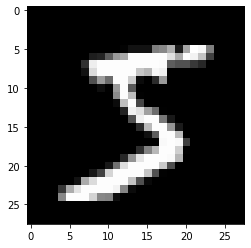

In [2]:
mnist_data = mnist.MNIST()
image_example = mnist_data.train_set.data[0]
plt.imshow(image_example, cmap='gray')

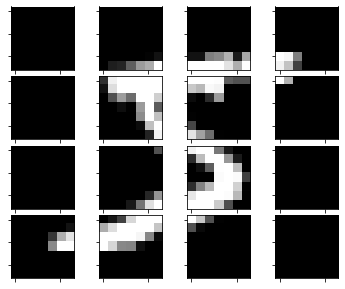

In [4]:
patches, patch_size = mnist.image_patching(image_example, num_patch=16)
display_patched_image(patches, patch_size)

Each subimage or patch above is taken as one observation in the image sample, so basically the image is viewed as a *sequence* of subimages.
There is still one remaining issue: It is quite important where each patch belongs to in the original image, in other words the position of each patch matters for recognizing the digits. Therefore, we add an identifier to each patch to contain the positional information. This identifier could be anything as long as it distinctively provides positional information for each patch and it is consitent across all the images. For example, you may want to use numbers from 1 to 16, so that the left bottom patch is identified by 1 and the right top one is identified by 16.

However, as in many other machine learning approaches, fusing features should be done with care. Adding positional information is not an exception, and therefore in practice this extra feature is added (or concatenated) to the patch representations in more subtle ways than adding integers or one-hot-encoding. This is beyond the scope of this tutorial, and we just use some positional embedding based on sinusoidal function to identify each image, and then concatenate it to the patch. So in the rest of this tutorial, it is not only the patch that goes to the self-attention layer, but also it's positional embedding.

In [48]:
def get_sinusoidal_encoding(num_patches, embedding_dim):
    assert embedding_dim % 2 == 0, "Embedding dimension must be even."
    position = torch.arange(num_patches).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(np.log(10000.0) / embedding_dim))
    positional_embedding = torch.zeros((num_patches, embedding_dim))
    positional_embedding[:, 0::2] = torch.sin(position * div_term)
    positional_embedding[:, 1::2] = torch.cos(position * div_term)
    return positional_embedding

num_patches = 16
embedding_dim = 10  # This should be the same as your patch embedding dimension
positional_embeddings = get_sinusoidal_encoding(num_patches, embedding_dim)


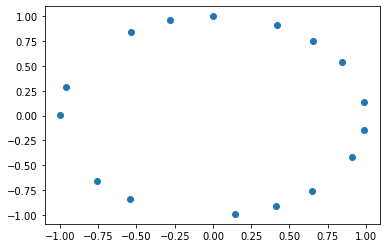

In [49]:
plt.scatter(x=positional_embeddings[:,0], y=positional_embeddings[:,1])

In [67]:
vectorized_position = torch.concat((unfolded.reshape(16,-1),  positional_embeddings), axis=1)

In [71]:
# we start with Query matrix
input_dim = vectorized_position.shape[1]
output_dim = 10
Q = torch.nn.Linear(input_dim, output_dim)
Q(vectorized_position).shape

torch.Size([16, 10])